# **JSON GoPro metadata processing**

# Affichage des données

First let us import the data. Change the paths if needed.

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open("../json/GH010025.MP4.json", "r") as f:
    video1_data1 = json.load(f)
with open("../json/GH020025.MP4.json", "r") as f:
    video1_data2 = json.load(f)

with open("../json/GH010024.MP4.json", "r") as f:
    video2_data1 = json.load(f)
with open("../json/GH020024.MP4.json", "r") as f:
    video2_data2 = json.load(f)
with open("../json/GH030024.MP4.json", "r") as f:
    video2_data3 = json.load(f)
list_data = [video1_data1, video1_data2, video2_data1, video2_data2, video2_data3]

The following 2 blocks of code allow to visualize the data to check if it is the correct data.

In [12]:
# Voir les clés principales
for i, data in enumerate(list_data):
    print(f"Data {i+1} keys:")
    print(data.keys())
    print()

Data 1 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 2 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 3 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 4 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])

Data 5 keys:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])



In [13]:
from pprint import pprint
with open("../json/GH010025.MP4.json", "r") as f:
    data = json.load(f)

# Affiche récursivement la structure jusqu’à une profondeur de 2 ou 3
for key in data:
    print(f"\n== Clé principale : {key} ==")
    if isinstance(data[key], dict):
        for subkey in data[key]:
            print(f"  - {subkey}: type={type(data[key][subkey])}")
            if isinstance(data[key][subkey], list) and len(data[key][subkey]) > 0:
                print(f"    Exemple d’entrée : {data[key][subkey][0]}")
    elif isinstance(data[key], list) and len(data[key]) > 0:
        print(f"  Liste de longueur {len(data[key])}")
        print(f"  Exemple d’entrée : {data[key][0]}")
    else:
        print(f"  Type: {type(data[key])}, Valeur: {data[key]}")


== Clé principale : img_timestamps_s ==
  Liste de longueur 42420
  Exemple d’entrée : 0.0

== Clé principale : ACCL ==
  - data: type=<class 'list'>
    Exemple d’entrée : [9.470023980815348, -1.223021582733813, 2.338129496402878]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GYRO ==
  - data: type=<class 'list'>
    Exemple d’entrée : [0.003194888178913738, 0.0, -0.0010649627263045794]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.001331

== Clé principale : GPS5 ==
  - data: type=<class 'list'>
    Exemple d’entrée : [48.6139418, 2.4291544, 96.877, 0.0, 0.0]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.050368

== Clé principale : GRAV ==
  - data: type=<class 'list'>
    Exemple d’entrée : [-0.12784203619495224, 0.9633777886288034, 0.23560289315469832]
  - timestamps_s: type=<class 'list'>
    Exemple d’entrée : 0.0

== Clé principale : MAGN ==
  - data: type=<class 'list'>
    Exemple d’entrée : [36.0,

The following block of code concatenates a list of multiple .MP4 GoPro metadata json variables into one for easier manipulation and interpretation into one .MP4 file.

In [16]:
# Créer les DataFrames pour toutes les clés de toutes les vidéos
list_data_video1 = [video1_data1, video1_data2]
list_data_video2 = [video2_data1, video2_data2, video2_data3]

def concatenate_dicts_by_key(dict_list):
    """
    Concatenates a list of dictionaries with potentially nested structures,
    ensuring that 'timestamps_s' values are stacked (i.e., made continuous).

    Parameters
    ----------
    dict_list : list of dict
        A list of dictionaries where each dictionary may contain nested structures

    Returns
    -------
    merged: dict.
        A single merged dictionary with combined and time-shifted values.
    """
    merged = {}
    time_offsets = {}  # Store per-key offset for nested timestamps

    for d in dict_list:
        for key, value in d.items():
            if isinstance(value, dict):
                # Nested dictionary (e.g., ACCL: {data: [...], timestamps_s: [...]})
                if key not in merged:
                    merged[key] = {}
                    time_offsets[key] = 0.0

                # Prepare nested structure if needed
                for sub_key, sub_val in value.items():
                    if sub_key not in merged[key]:
                        merged[key][sub_key] = []

                    if sub_key == "timestamps_s":
                        # Offset this timestamp list
                        offset = time_offsets[key]
                        shifted = [t + offset for t in sub_val]
                        merged[key][sub_key].extend(shifted)

                        # Update offset: assume timestamps_s is sorted
                        if sub_val:
                            time_offsets[key] += sub_val[-1] - sub_val[0]
                    else:
                        merged[key][sub_key].extend(sub_val)

            elif isinstance(value, list):
                # Flat key like img_timestamps_s (we treat it like timestamps)
                if key not in merged:
                    merged[key] = []
                    time_offsets[key] = 0.0

                if key.endswith("timestamps_s"):
                    offset = time_offsets[key]
                    shifted = [t + offset for t in value]
                    merged[key].extend(shifted)
                    if value:
                        time_offsets[key] += value[-1] - value[0]
                else:
                    merged[key].extend(value)

            else:
                print(f"Unexpected value type for key '{key}': {type(value)}")
                if key not in merged:
                    merged[key] = []
                merged[key].append(value)

    return merged


data_video1 = concatenate_dicts_by_key(list_data_video1)
data_video2 = concatenate_dicts_by_key(list_data_video2)

The following block checks if the concatenation worked by displaying the results.

In [17]:
print("Data Video 1:")
print(data_video1.keys())
key = "ACCL"
samples = data_video1[key]
print(f"Number of samples in {key}: {len(samples)}")

print("Data Video 2:")
print(data_video2.keys())

# Print the length of the ACCL samples before and after the concatenation
print(f"Number of samples in {key}: {len(data_video1[key]['data'])}")
print(f"Number of samples in {key}: {len(video1_data1[key]['data'])} +", f"{len(video1_data2[key]['data'])}", f"= {len(video1_data1[key]['data']) + len(video1_data2[key]['data'])}")

Data Video 1:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 2
Data Video 2:
dict_keys(['img_timestamps_s', 'ACCL', 'GYRO', 'GPS5', 'GRAV', 'MAGN', 'CORI', 'IORI'])
Number of samples in ACCL: 237913
Number of samples in ACCL: 141058 + 96855 = 237913


The following blocks plot all sensor data with one graph for each sensor and each video.

In [ ]:
def parse_video_dict(video_dict):
    """
    Converts a sensor dictionary into a dict of DataFrames per sensor (one DataFrame for ACCL, one for GRAV and so on).
    """
    dict_of_dfs = {}
    for key, value in video_dict.items():
        # Skip if key is just the image timestamps
        if key == "img_timestamps_s":
            continue

        if isinstance(value, dict) and "data" in value and "timestamps_s" in value:
            samples = value["data"]
            timestamps = value["timestamps_s"]

            # Skip if no data or inconsistent
            if not samples or not timestamps or len(samples) != len(timestamps):
                print(f"Skipping {key}: no data or inconsistent lengths.")
                continue

            num_cols = len(samples[0]) if isinstance(samples[0], (list, tuple)) else 1# check if samples is a list of lists or a single list
            if num_cols == 1:
                df = pd.DataFrame({f"{key}_0": samples})
            else:
                col_names = [f"{key}_{i}" for i in range(num_cols)]
                df = pd.DataFrame(samples, columns=col_names)

            df["time"] = timestamps
            df["time_rel"] = df["time"] - df["time"][0] # starting from 0 for plotting
            dict_of_dfs[key] = df

    return dict_of_dfs

def plot_sensor_data(dict_of_dfs, label_prefix=""):
    """
    Plots all sensor data from a dict of DataFrames.
    """
    for key, df in dict_of_dfs.items():
        if df.empty or "time_rel" not in df:
            print(f"Skipping {key}: DataFrame is empty or missing 'time_rel' column.")
            continue

        value_cols = [col for col in df.columns if col not in ["time", "time_rel"]]
        plt.figure(figsize=(10, 5))
        for col in value_cols:
            plt.plot(df["time_rel"], df[col], label=col)

        plt.xlabel("Temps relatif (s)")
        plt.ylabel(f"Valeurs ({key})")
        plt.title(f"{label_prefix}{key} en fonction du temps")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Create DataFrames for each video
dfs_video_1 = parse_video_dict(data_video1)
dfs_video_2 = parse_video_dict(data_video2)

# Verifies that the DataFrames were created correctly with 1 column for index, 1 for timestamps, and 3-5 for data
print("DataFrames for Video 1:")
for key, df in dfs_video_1.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")
print("DataFrames for Video 2:")
for key, df in dfs_video_2.items():
    print(f"{key}: {df.shape[0]} rows, {df.shape[1]} columns")

DataFrames for Video 1:
ACCL: 237913 rows, 5 columns
GYRO: 237913 rows, 5 columns
GPS5: 21569 rows, 7 columns
GRAV: 71552 rows, 5 columns
MAGN: 29739 rows, 5 columns
CORI: 71552 rows, 6 columns
IORI: 71552 rows, 6 columns
DataFrames for Video 2:
ACCL: 313522 rows, 5 columns
GYRO: 313522 rows, 5 columns
GPS5: 28557 rows, 7 columns
GRAV: 94300 rows, 5 columns
MAGN: 39190 rows, 5 columns
CORI: 94300 rows, 6 columns
IORI: 94300 rows, 6 columns


Video 1 DataFrames: ----------------------------------------------------------------------------------------------------


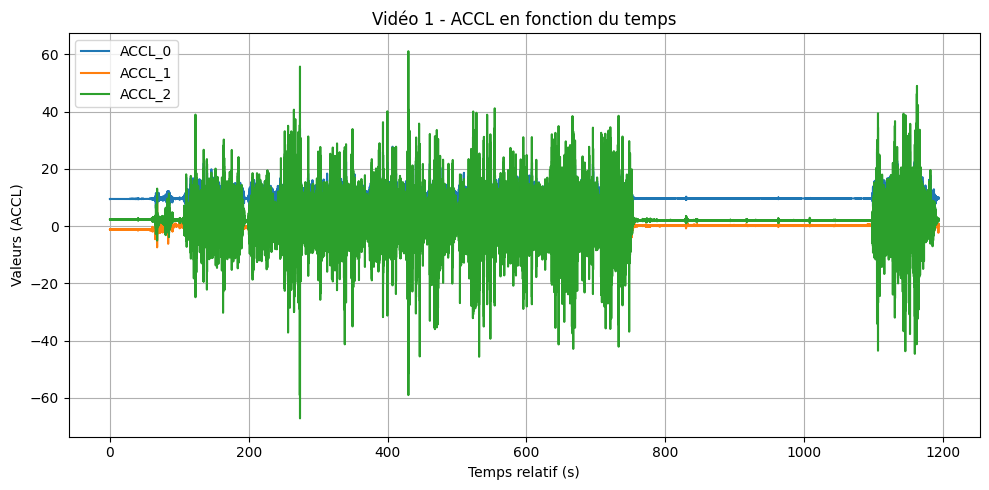

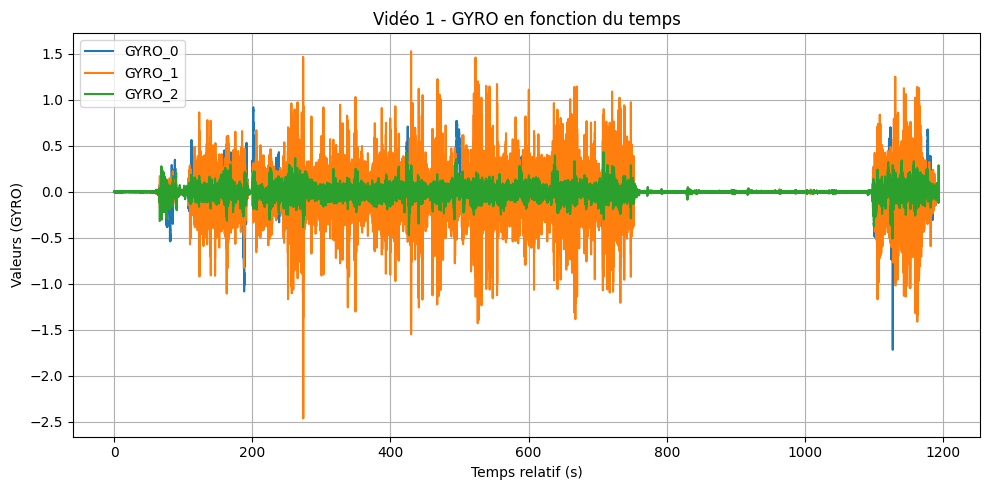

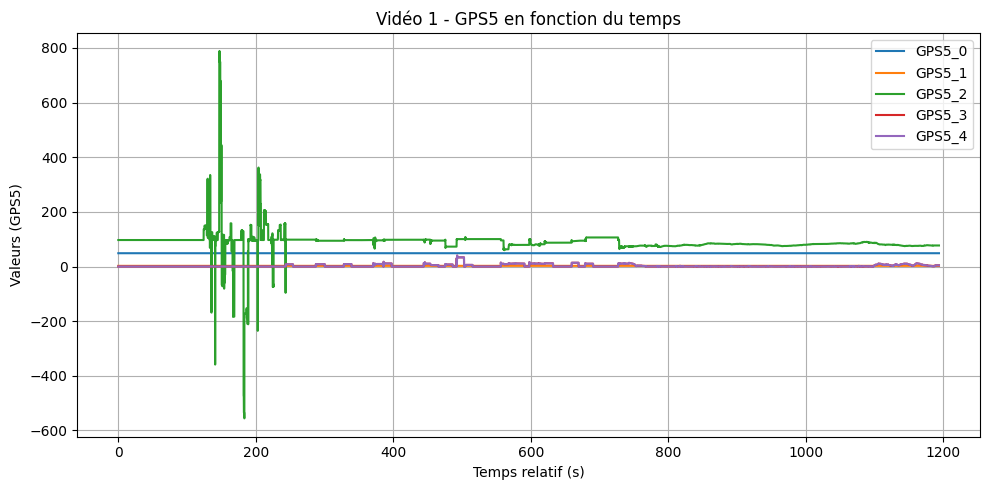

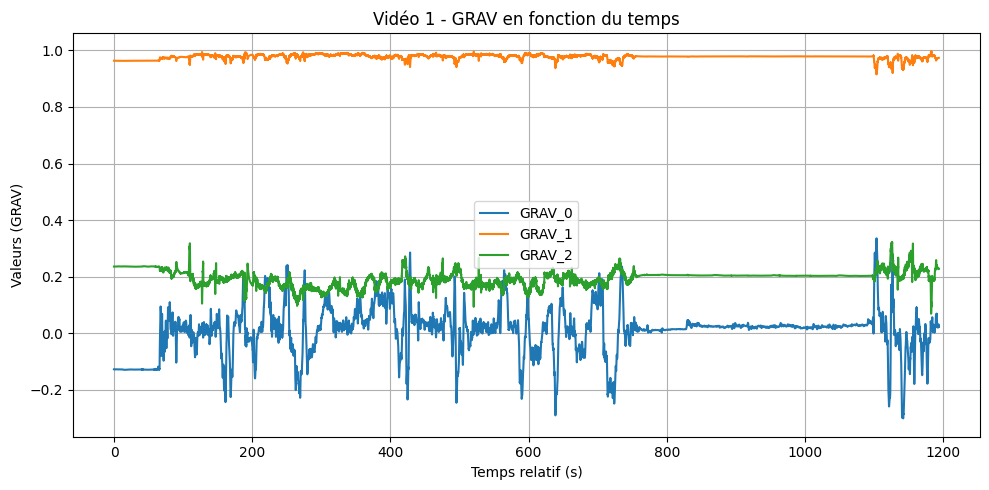

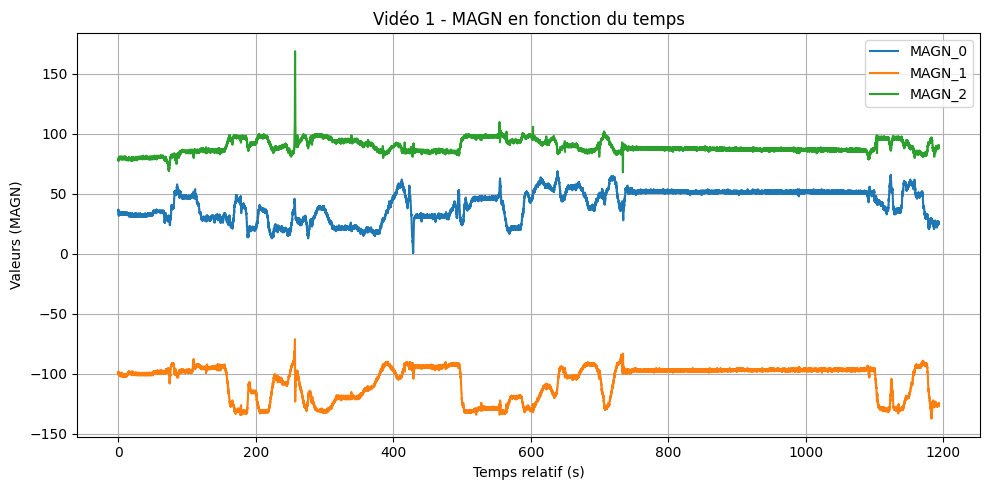

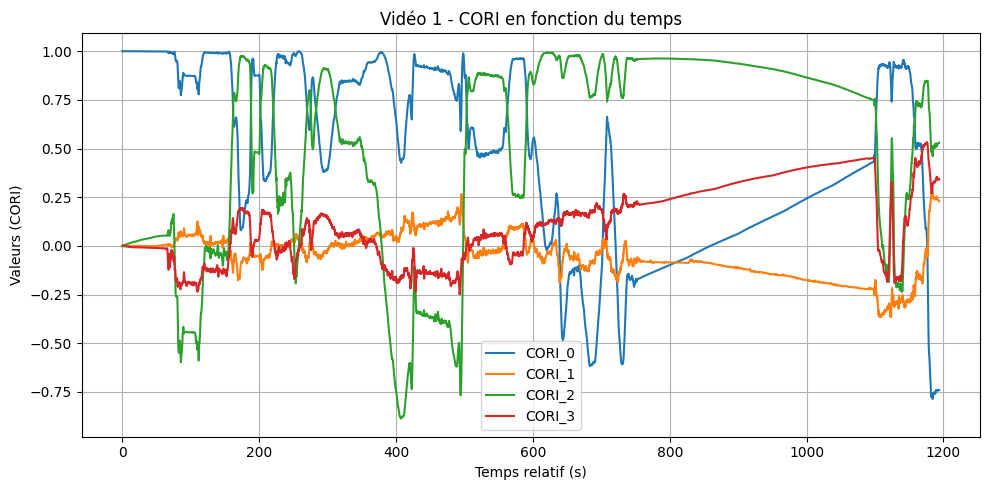

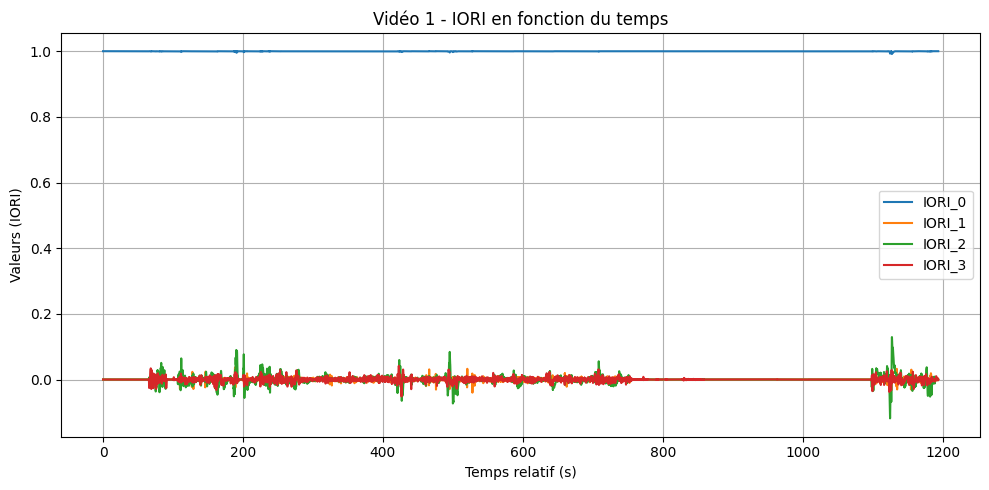

Video 2 DataFrames: ----------------------------------------------------------------------------------------------------


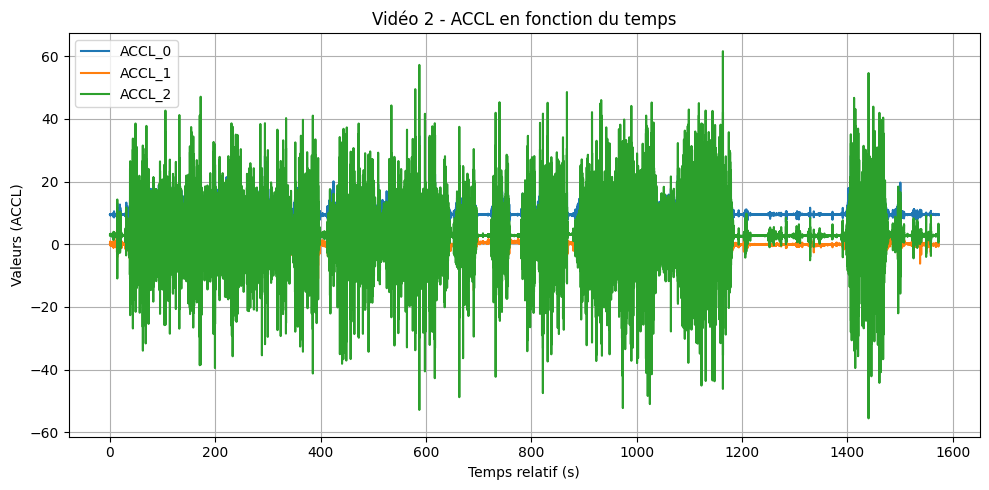

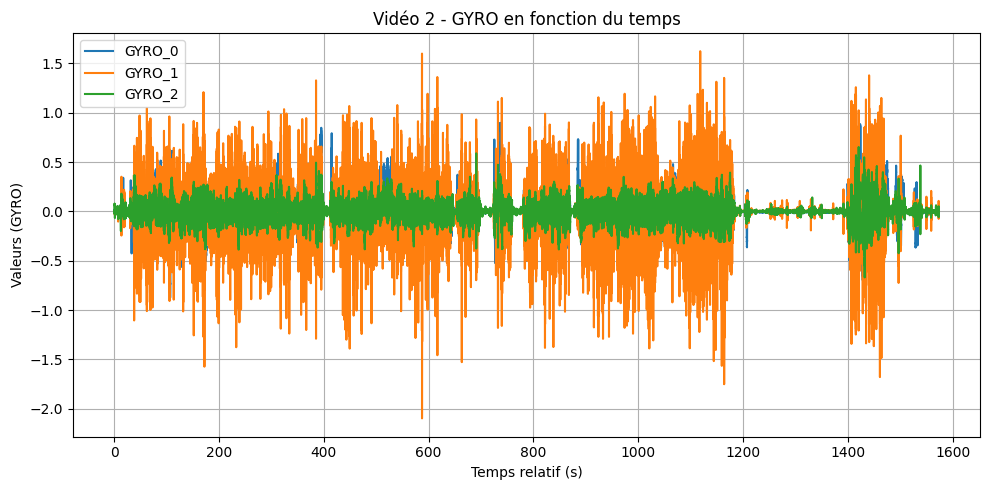

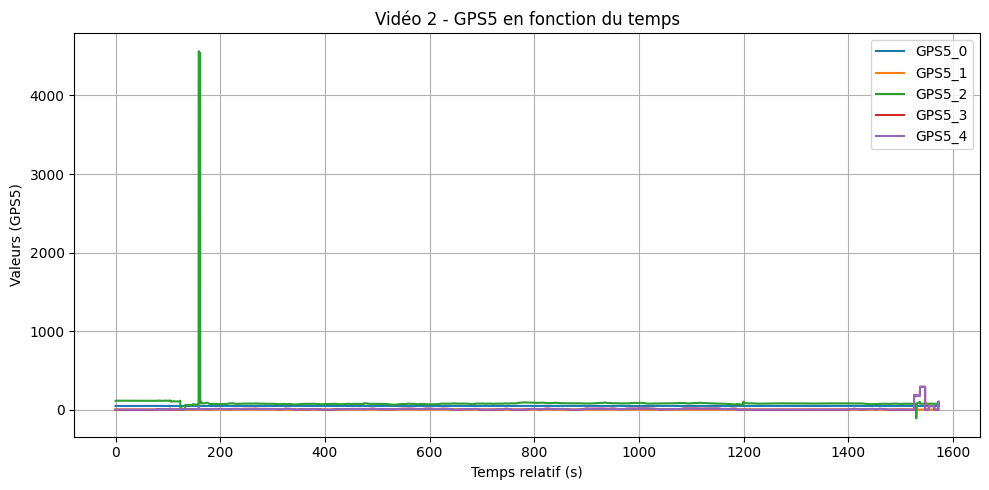

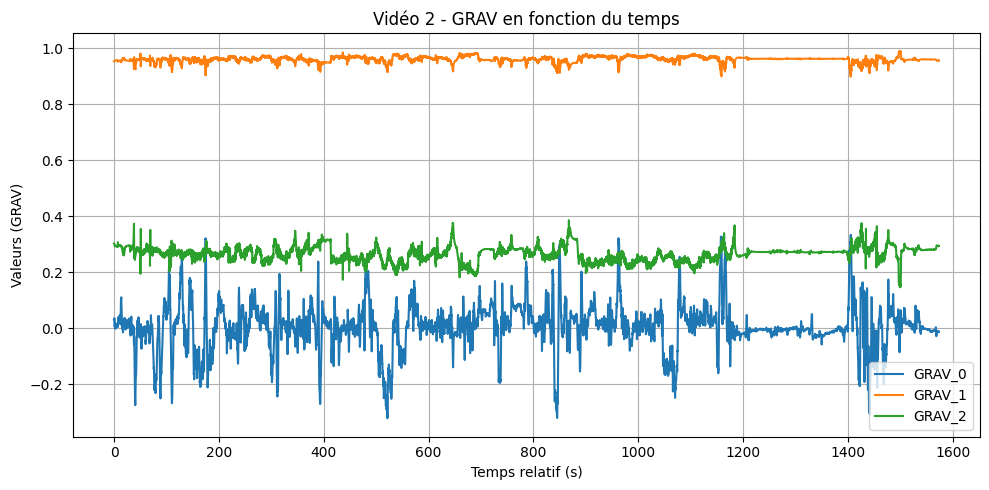

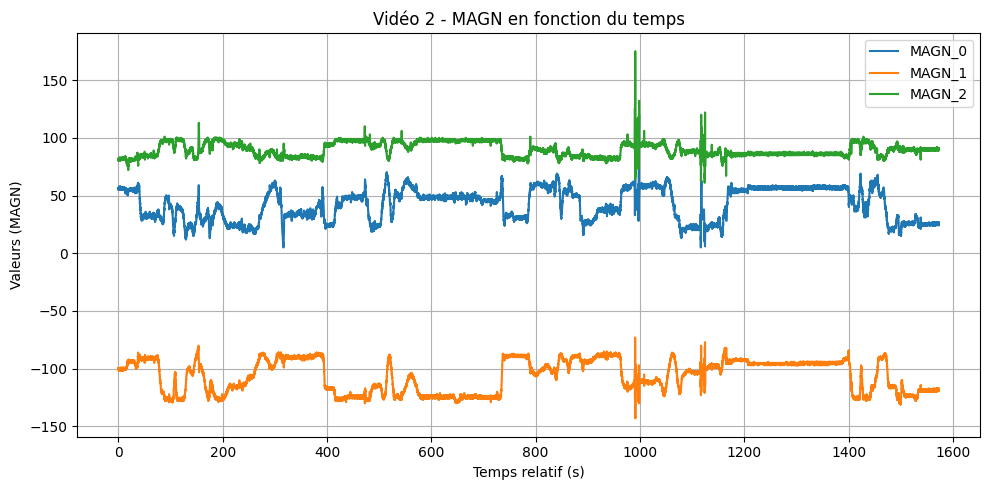

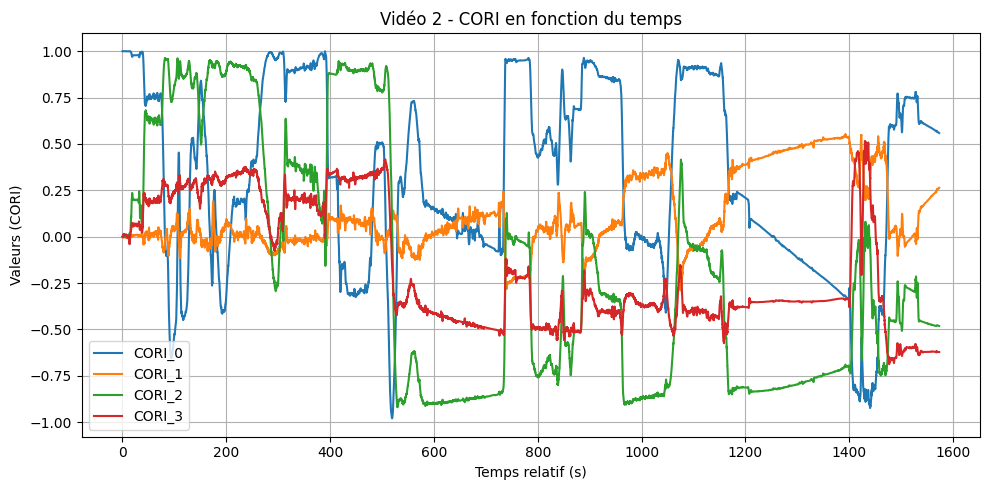

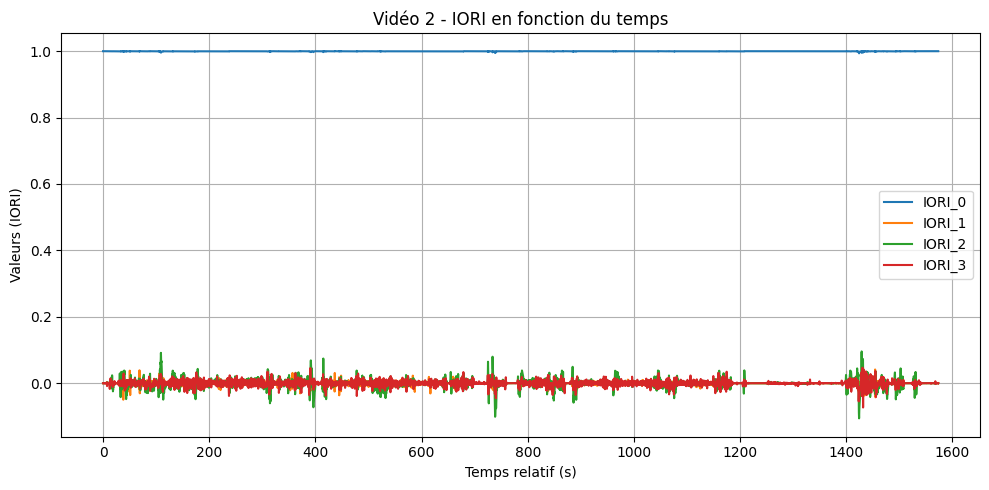

In [19]:
# Plot sensor data for each video
print("Video 1 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_1, label_prefix="Vidéo 1 - ")
print("Video 2 DataFrames:", "-" * 100)
plot_sensor_data(dfs_video_2, label_prefix="Vidéo 2 - ")

The acceleration data is consistent with the observation of the video, which indicates that the data processing was successful. The moments when the camera is stationary, as the `ACCL` acceleration is zero, correspond to the moments when the stabilized orientation `IORO` is at its lowest, indicating that the graphs are consistent with each other.



### Graph analysis
* **Acceleration**: `ACCL_2` corresponds to the forward/backward acceleration of the motorcycle because it is positively non-zero on average, `ACCL_0` to vertical acceleration since its average is close to 10, which matches Earth's acceleration, and `ACCL_1` corresponds to lateral acceleration since it is zero on average, indicating that the road is mostly straight.
* **Gyroscope**:
* **GPS**: there are sometimes outlier data points (spikes) that should be removed.
* **Gravity**: `GRAV_1` corresponds to vertical acceleration as it is close to $1\ g$, `GRAV_2` to forward/backward acceleration because it is non-zero and positive, and therefore `GRAV_0` corresponds to lateral acceleration.
* **Magnetic field**:
* **Camera orientation**:
* **GoPro stabilized orientation**:

## Comparison with [GoPro Telemetry Extractor](https://goprotelemetryextractor.com/free/)
The graph output doesn't seem to be the same ?

# Calcul du roulis, lacet, et tangage de la moto

## Roll, pitch and yaw
We use various GoPro metadata to compute roll, pitch and yaw then using multiple filter methods to ensure the most precise values.

### Roll, pitch and yaw from gyroscope (from `GYRO` values)
Integration of angular velocity:
```python
roll[i+1]  = roll[i] + gyro_x[i] * Δt
pitch[i+1] = pitch[i] + gyro_y[i] * Δt
yaw[i+1]   = yaw[i] + gyro_z[i] * Δt
```
But these values drift over time (gyroscope bias) from reality because of the small approximation mistakes each time ([source](https://vanhunteradams.com/Pico/ReactionWheel/))

In [48]:
def integrate_gyro_orientation_from_dict(dfs, time_col='time_rel'):
    """
    Compute orientation angles (in degrees) by integrating gyroscope angular velocities.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary where each key corresponds to a sensor name (e.g., 'GYRO', 'ACCL'),
        and each value is a DataFrame with time and sensor measurements.
        The 'GYRO' DataFrame must contain columns: 'GYRO_0', 'GYRO_1', 'GYRO_2' in rad/s.

    time_col : str
        Column name representing time in seconds, typically 'time_rel'.

    Returns
    -------
    pd.DataFrame
        A new DataFrame containing time and the integrated orientation angles:
        'Yaw', 'Pitch', 'Roll', corresponding to the three gyroscope axes.
    """
    # Check if the list has en element "GYRO"
    if "GYRO" not in dfs:
        raise ValueError("Missing 'GYRO' data in input dictionary.")

    df_gyro = dfs["GYRO"].copy()

    # Check if all columns are in the DataFrame
    if not all(col in df_gyro.columns for col in ["GYRO_0", "GYRO_1", "GYRO_2", time_col]):
        raise ValueError("The 'GYRO' DataFrame must contain 'GYRO_0', 'GYRO_1', 'GYRO_2' and the specified time column.")

    # Select 3 columns
    gyro = df_gyro[["GYRO_0", "GYRO_1", "GYRO_2"]].values
    # Select 1 column
    time = df_gyro[time_col].values

    # Computes the difference between each consecutive value
    dt = np.diff(time, prepend=time[0])

    orientation = np.zeros_like(gyro)

    # Computes each value
    for i in range(1, len(gyro)):
        orientation[i] = orientation[i - 1] + gyro[i] * dt[i]

    # Copies the value of the first row in the second for more continuity
    orientation[0] = orientation[1]

    # Convert rad to degrees
    orientation_deg = np.degrees(orientation)

    df_orientation = pd.DataFrame({
        time_col: time,
        "roll": orientation_deg[:, 2], # first column
        "pitch": orientation_deg[:, 1], # second column
        "yaw": orientation_deg[:, 0], # third column
    })

    return df_orientation

roll_pitch_yaw_gyro_1 = integrate_gyro_orientation_from_dict(dfs_video_1)
roll_pitch_yaw_gyro_2 = integrate_gyro_orientation_from_dict(dfs_video_2)

After analysing the video with the graph on the side, `GYRO_0` seems to be yaw. Indeed, when looking at the right and left turns to the video, they match the graph values in degrees.

`GYRO_2` seems to correspond to roll as the change in the change in yaw related to turning left or right correspond to the change of `GYRO_2` thus matching the graph shape. When then bike is turning it is also swinging thus leading to changes in roll.

Thus `GYRO_1` is pitch and the graph shape is mainly small integration mistakes picked along the video (see below).

It is worth noting that the drift appears clear thoughout the video as values drift up to more than 600 degrees while it is clear in the video that all except yaw must be equal to 0 at the end!

Let us display the data.

Video 1: ----------------------------------------------------------------------------------------------------


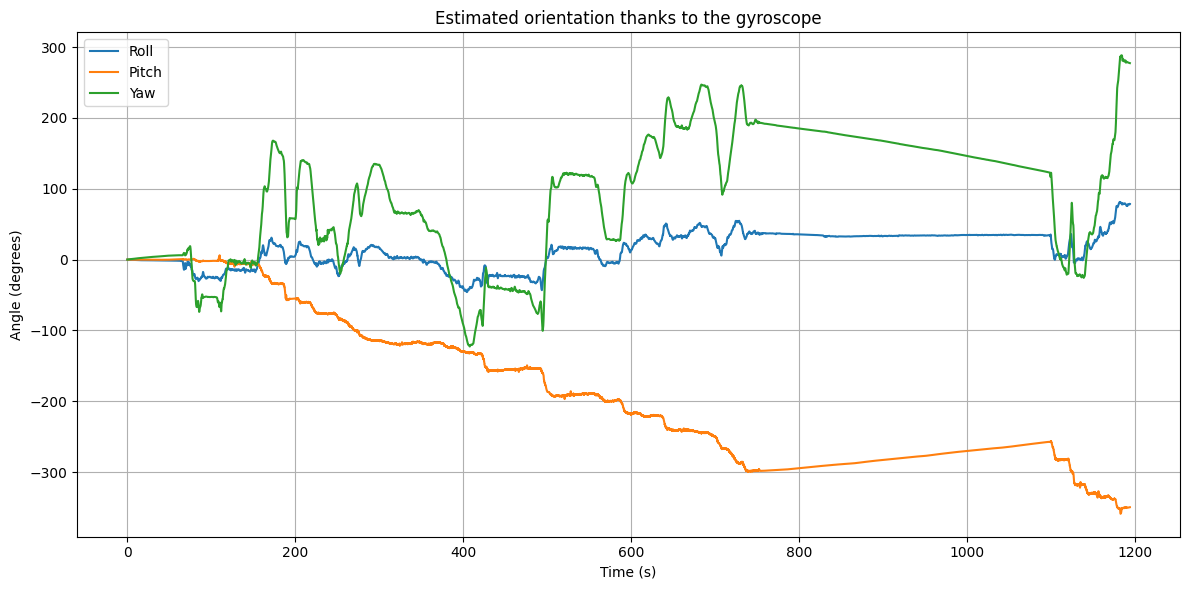

Video 2: ----------------------------------------------------------------------------------------------------


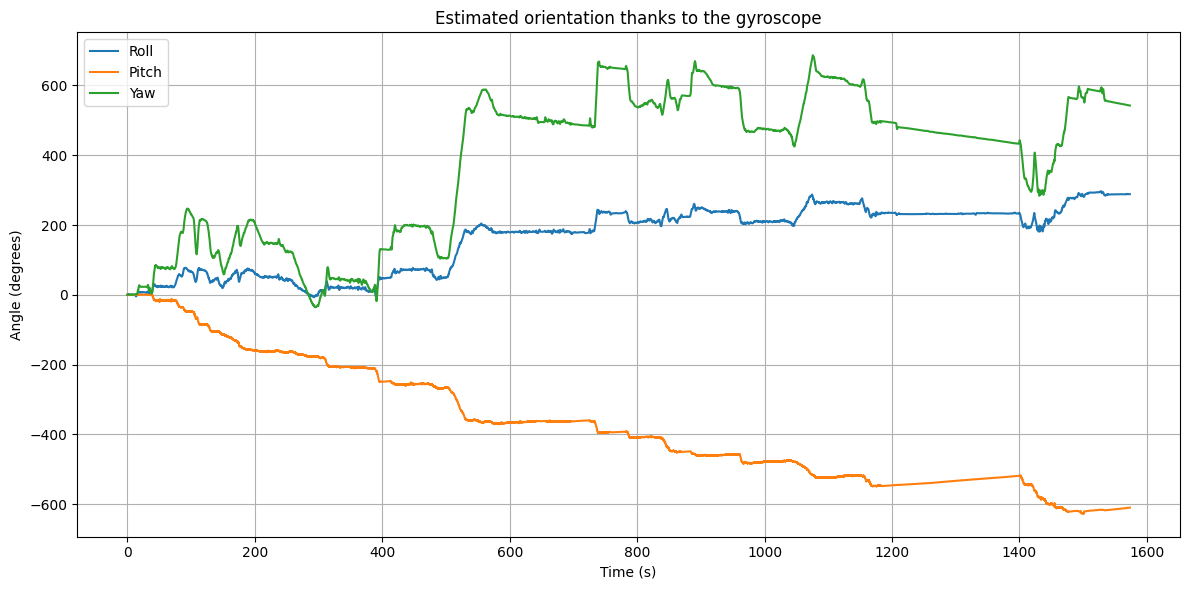

In [49]:
def display_df(df_orientation, time_col="time_rel"):
    """
    Plot roll, pitch, yaw (Yaw, Pitch, Roll) over time.

    Parameters
    ----------
    df_orientation : pd.DataFrame
        DataFrame containing orientation columns: 'roll', 'pitch', 'yaw', and a time column.

    time_col : str
        Name of the time column, typically 'time_rel'.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df_orientation[time_col], df_orientation["roll"], label="Roll")
    plt.plot(df_orientation[time_col], df_orientation["pitch"], label="Pitch")
    plt.plot(df_orientation[time_col], df_orientation["yaw"], label="Yaw")
    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Estimated orientation thanks to the gyroscope")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
display_df(roll_pitch_yaw_gyro_1)
print("Video 2:", "-" * 100)
display_df(roll_pitch_yaw_gyro_2)


### Roll and pitch from accelerometer
Static estimation: because gravity is always down, you can project it on the sensor frame.
```python
roll  = atan2(acc_y, acc_z)
pitch = atan2(-acc_x, sqrt(acc_y**2 + acc_z**2))
```
This gives good long-term orientation to correct for the first indicator, but poor during acceleration or vibration. Indeed, if the device is moving, accelerating, or vibrating, the acceleration includes not only motion, shocks, engine vibration, bumps from the vehicle. But in this case the acceleration is at most a few $g$ ([source](https://vanhunteradams.com/Pico/ReactionWheel/)).

As seen before,
* ACCL_0: vertical (gravity-aligned)
* ACCL_1: lateral (side-to-side)
* ACCL_2: longitudinal (forward/backward)

Thus, the roll comes from ACCL_1 vs ACCL_0, and pitch from ACCL_2 vs sqrt(ACCL_1² + ACCL_0²).

In [45]:
def estimate_orientation_from_accelerometer(dfs, time_col="time_rel"):
    """
    Estimate roll and pitch from accelerometer using static orientation formulas.

    Assumes that the only acceleration is due to gravity (i.e., no motion or vibration).
    Yaw cannot be estimated from the accelerometer alone.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary containing sensor data. Must include 'ACCL' key with a DataFrame
        containing accelerometer columns: 'ACCL_0', 'ACCL_1', 'ACCL_2' (in m/s² or g),
        and a time column.

    time_col : str
        Name of the time column, typically 'time_rel'.

    Returns
    -------
    pd.DataFrame
        DataFrame with time and estimated 'roll_accel' and 'pitch_accel' in degrees.
    """
    if "ACCL" not in dfs:
        raise ValueError("Missing 'ACCL' data in input dictionary.")

    df_acc = dfs["ACCL"].copy()

    if not all(col in df_acc.columns for col in ["ACCL_0", "ACCL_1", "ACCL_2", time_col]):
        raise ValueError("The 'ACCL' DataFrame must contain 'ACCL_0', 'ACCL_1', 'ACCL_2' and the specified time column.")

    acc_vert = df_acc["ACCL_0"].values      # vertical
    acc_lat = df_acc["ACCL_1"].values       # lateral
    acc_long = df_acc["ACCL_2"].values      # forward/backward

    # Static estimation using gravity direction
    roll = np.arctan2(acc_lat, acc_vert)
    pitch = np.arctan2(-acc_long, np.sqrt(acc_lat**2 + acc_vert**2))

    # Convert to degrees
    roll_deg = np.degrees(roll)
    pitch_deg = np.degrees(pitch)

    # Set the first value to be equal to the second (copy)
    acc_vert[0] = acc_vert[1]
    acc_lat[0] = acc_lat[1]
    acc_long[0] = acc_long[1]

    return pd.DataFrame({
        time_col: df_acc[time_col],
        "roll_accl": roll_deg,
        "pitch_accl": pitch_deg
    })

roll_pitch_acc_1 = estimate_orientation_from_accelerometer(dfs_video_1)
roll_pitch_acc_2 = estimate_orientation_from_accelerometer(dfs_video_2)

Video 1: ----------------------------------------------------------------------------------------------------


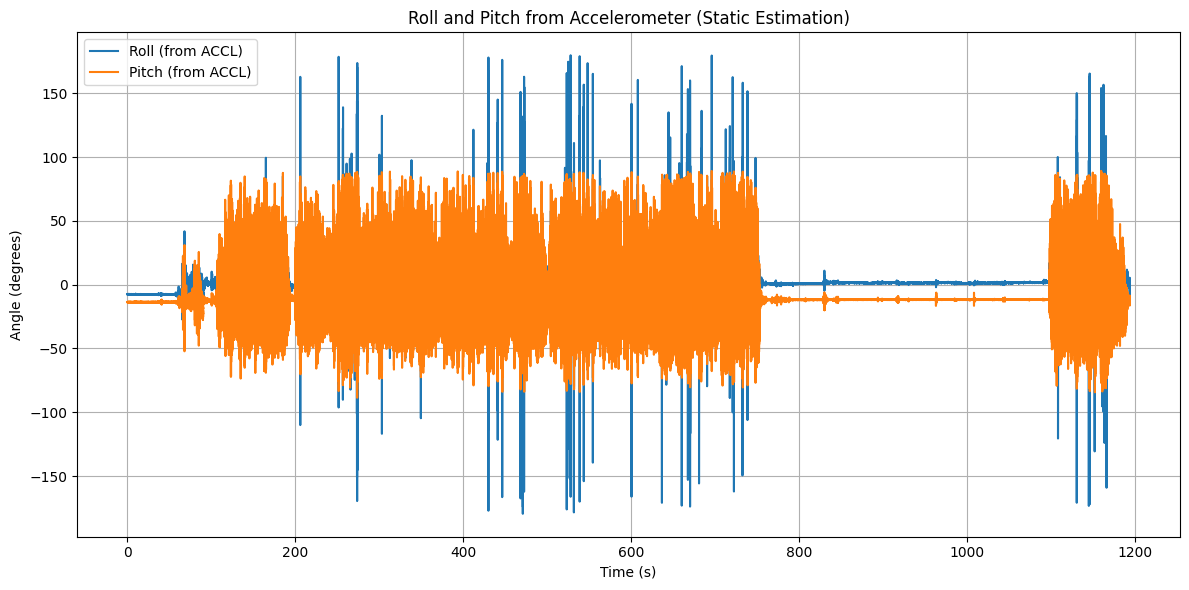

Video 2: ----------------------------------------------------------------------------------------------------


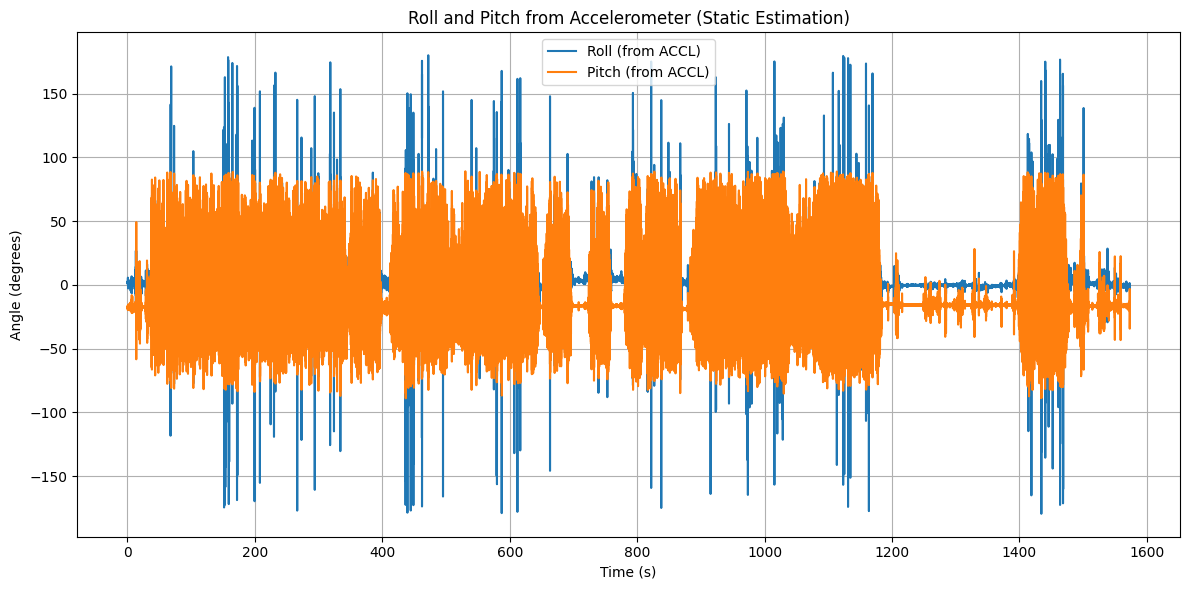

In [46]:
def plot_accel_orientation(df_accel_orientation, time_col="time_rel"):
    """
    Plot roll and pitch angles estimated from accelerometer data.

    Parameters
    ----------
    df_accel_orientation : pd.DataFrame
        DataFrame containing accelerometer-based orientation estimates.
        Must include 'roll_accl', 'pitch_accl', and a time column.

    time_col : str
        Name of the column representing time (default is 'time_rel').
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df_accel_orientation[time_col], df_accel_orientation["roll_accl"], label="Roll (from ACCL)")
    plt.plot(df_accel_orientation[time_col], df_accel_orientation["pitch_accl"], label="Pitch (from ACCL)")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Roll and Pitch from Accelerometer (Static Estimation)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_accel_orientation(roll_pitch_acc_1)
print("Video 2:", "-" * 100)
plot_accel_orientation(roll_pitch_acc_2)

Graph analysis: I guess roll is bigger than pitch in this case as the bike is turning left, it is gaining much more roll than pitch when the bike is speeding or slowing down ?

Note this graph is way more erratic than the precedent because it is picking small changes way stronger but it is more relevant long-term.

### Yaw from compass

In [30]:
def compute_yaw_from_compass(dfs, time_col="time_rel"):
    """
    Compute yaw (heading) from magnetometer data.

    Assumes flat terrain (no tilt compensation). If the device is tilted, this estimate becomes inaccurate.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary containing sensor data. Must include 'MAGN' key with a DataFrame
        containing magnetometer columns: 'MAGN_0', 'MAGN_1', 'MAGN_2' and a time column.

    time_col : str
        Name of the time column (usually 'time_rel').

    Returns
    -------
    pd.DataFrame
        DataFrame with time and estimated 'yaw_magn' (in degrees).
    """
    if "MAGN" not in dfs:
        raise ValueError("Missing 'MAGN' data in input dictionary.")

    df_magn = dfs["MAGN"].copy()

    if not all(col in df_magn.columns for col in ["MAGN_0", "MAGN_1", time_col]):
        raise ValueError("The 'MAGN' DataFrame must contain 'MAGN_0', 'MAGN_1' and the specified time column.")

    magn_x = df_magn["MAGN_0"].values
    magn_y = df_magn["MAGN_1"].values

    # Heading (yaw) in radians
    yaw_rad = np.arctan2(magn_y, magn_x)

    # Convert to degrees and normalize to [0, 360)
    yaw_deg = np.degrees(yaw_rad) % 360

    magn_x[0] = magn_x[1]
    magn_y[0] = magn_y[1]

    return pd.DataFrame({
        time_col: df_magn[time_col],
        "yaw_magn": yaw_deg
    })

yaw_magn_1 = compute_yaw_from_compass(dfs_video_1)
yaw_magn_2 = compute_yaw_from_compass(dfs_video_2)

Video 1: ----------------------------------------------------------------------------------------------------


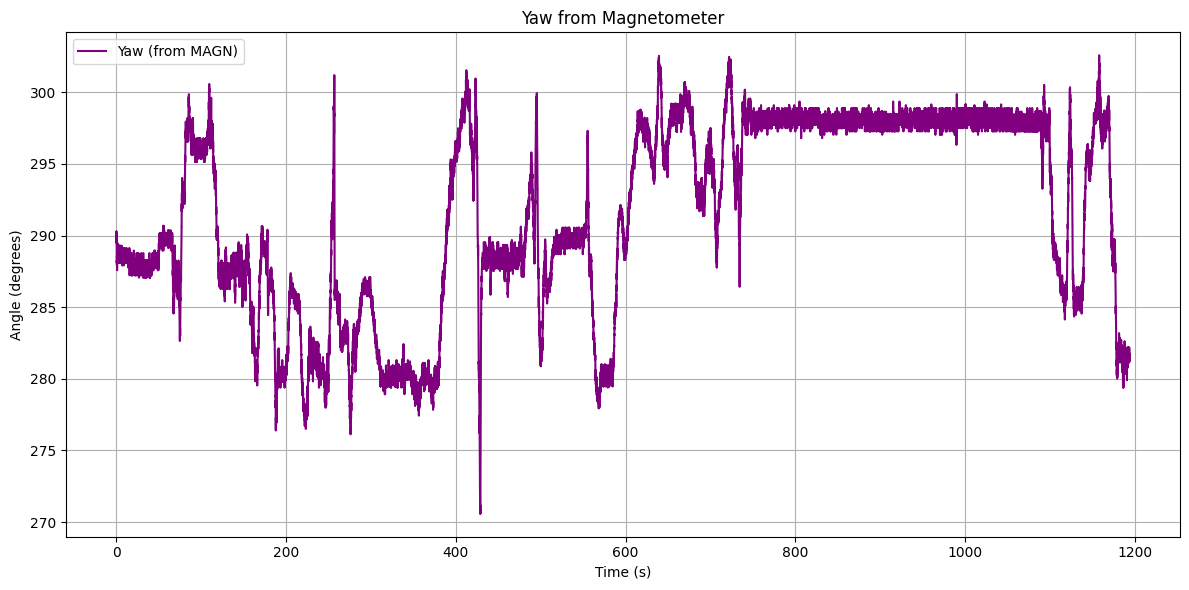

Video 2: ----------------------------------------------------------------------------------------------------


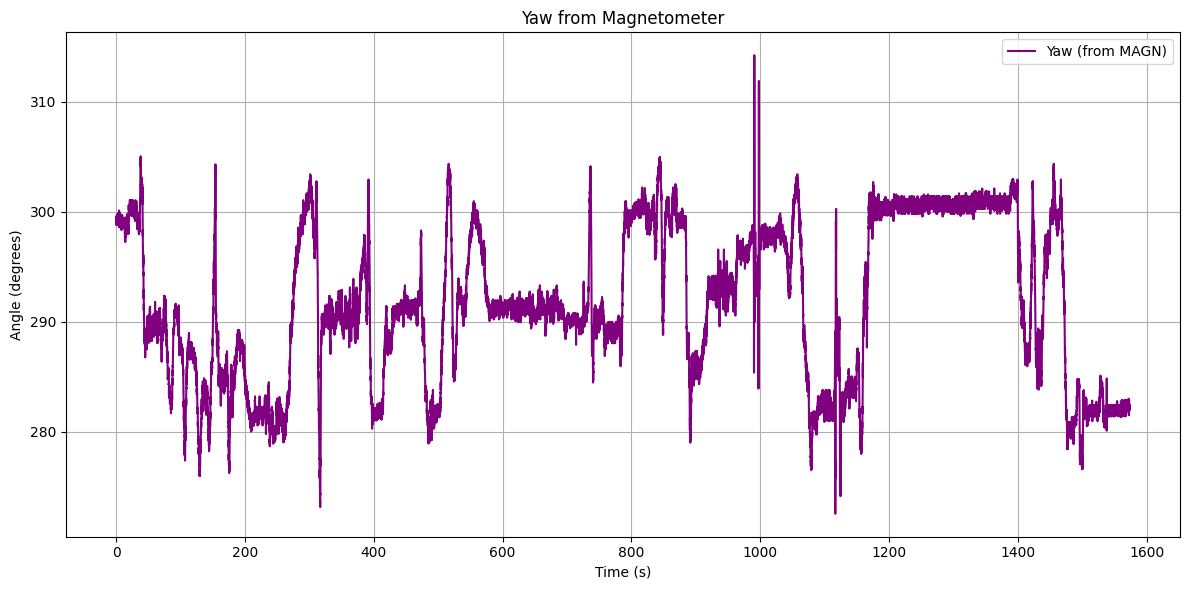

In [31]:
def plot_yaw_from_magnetometer(df, time_col="time_rel", yaw_col="yaw_magn"):
    """
    Plot yaw angle over time as estimated from magnetometer data.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing yaw angle and time columns.
    time_col : str
        Column name representing time in seconds (default is "time_rel").
    yaw_col : str
        Column name for yaw angle in degrees (default is "yaw_magn").
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df[time_col], df[yaw_col], label="Yaw (from MAGN)", color="purple")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Yaw from Magnetometer")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_yaw_from_magnetometer(yaw_magn_1)
print("Video 2:", "-" * 100)
plot_yaw_from_magnetometer(yaw_magn_2)

## Filters

### Complentary filter: blend both previous estimates
This method combines the first and second steps.
With `gyro_weight` being a tuning parameter:
```python
roll  = gyro_weight * (roll + gyro_x * Δt) + (1 - gyro_weight) * roll_acc
pitch = gyro_weight * (pitch + gyro_y * Δt) + (1 - gyro_weight) * pitch_acc
```
You get short-term reactivity from the gyroscope, and long-term stability from the accelerometer.

Issue : the magnometer runs at 25 Hz while accelerometer and gyroscope run at 200 Hz.

The following function solves the issue by keeping only rows that have a common `time_rel` column.

In [ ]:
def align_erase_df(*dfs, time_col='time_rel'):
    """
    Align multiple DataFrames by keeping only the rows with common time_rel values.

    Parameters
    ----------
    *dfs : pd.DataFrame
        Arbitrary number of DataFrames each with a time_col.
    time_col : str, optional
        Name of the time column (default is 'time_rel').

    Returns
    -------
    list of pd.DataFrame
        List of DataFrames aligned on common time values, with indices reset.
    """
    if not dfs:
        return []

    # Find common time values
    common_times = set(dfs[0][time_col])
    for df in dfs[1:]:
        common_times &= set(df[time_col])

    # Convert to sorted list
    common_times = sorted(common_times)

    # Filter each DataFrame and reset index
    aligned_dfs = [df[df[time_col].isin(common_times)].reset_index(drop=True) for df in dfs]
    
    return aligned_dfs

aligned_roll_pitch_yaw_gyro_1, aligned_roll_pitch_acc_1, aligned_yaw_magn_1 = align_erase_df(roll_pitch_yaw_gyro_1, roll_pitch_acc_1, yaw_magn_1)
aligned_roll_pitch_yaw_gyro_2, aligned_roll_pitch_acc_2, aligned_yaw_magn_2 = align_erase_df(roll_pitch_yaw_gyro_2, roll_pitch_acc_2, yaw_magn_2)

Same here but by interpolating.

In [94]:
def align_and_forward_fill_to_max_timebase(*dfs, time_col='time_rel'):
    """
    Align multiple DataFrames by expanding all to the union of time_rel values,
    and filling missing values using forward fill (last known value).

    Parameters
    ----------
    *dfs : pd.DataFrame
        DataFrames with a time_col to align.
    time_col : str, optional
        Name of the time column (default is 'time_rel').

    Returns
    -------
    list of pd.DataFrame
        List of DataFrames aligned to the full union of time_rel, forward-filled.
    """
    if not dfs:
        return []

    # Union of all time_rel values
    all_times = sorted(set().union(*(df[time_col] for df in dfs)))

    aligned_dfs = []
    for df in dfs:
        df = df.copy()

        # Remove time_rel from index if it's there
        if time_col in df.index.names:
            df = df.reset_index()

        # Sort by time_col to ensure forward-fill works
        df = df.sort_values(by=time_col)

        # Set time_col as index
        df = df.set_index(time_col)

        # Reindex and forward-fill missing values
        df = df.reindex(all_times)  # reindex to union
        df = df.ffill()  # forward fill
        df = df.reset_index().rename(columns={"index": time_col})  # restore time_col

        aligned_dfs.append(df)

    return aligned_dfs

aligned_roll_pitch_yaw_gyro_1, aligned_roll_pitch_acc_1, aligned_yaw_magn_1 = align_and_forward_fill_to_max_timebase(roll_pitch_yaw_gyro_1, roll_pitch_acc_1, yaw_magn_1)
aligned_roll_pitch_yaw_gyro_2, aligned_roll_pitch_acc_2, aligned_yaw_magn_2 = align_and_forward_fill_to_max_timebase(roll_pitch_yaw_gyro_2, roll_pitch_acc_2, yaw_magn_2)

ValueError: cannot insert time_rel, already exists

In [91]:
def complementary_filter_fusion(gyro_angles, acc_angles, magn_yaw, gyro_weight=0.999):
    """
    Fuse orientation data using a complementary filter.

    Parameters
    ----------
    gyro_angles : pd.DataFrame
        DataFrame with columns ['roll', 'pitch', 'yaw', 'time_rel'].
    acc_angles : pd.DataFrame
        DataFrame with columns ['roll_accl', 'pitch_accl', 'time_rel'].
    magn_yaw : pd.DataFrame
        DataFrame with columns ['yaw_magn', 'time_rel'].
    gyro_weight : float
        Weight for the gyroscope data (0 < gyro_weight < 1).

    Returns
    -------
    pd.DataFrame
        DataFrame with fused 'roll', 'pitch', 'yaw' and 'time_rel'.
    """
    # Interpolate accelerometer and magnetometer to gyro timestamps
    time_base = gyro_angles['time_rel']

    fused = pd.DataFrame({'time_rel': time_base})
    fused['roll'] = gyro_weight * gyro_angles['roll'] + (1 - gyro_weight) * acc_angles ['roll_accl']
    fused['pitch'] = gyro_weight * gyro_angles['pitch'] + (1 - gyro_weight) * acc_angles['pitch_accl']
    fused['yaw'] = gyro_weight * gyro_angles['yaw'] + (1 - gyro_weight) * magn_yaw['yaw_magn']

    return fused

complementary_filter_1 = complementary_filter_fusion(aligned_roll_pitch_yaw_gyro_1, aligned_roll_pitch_acc_1, aligned_yaw_magn_1)
complementary_filter_2 = complementary_filter_fusion(aligned_roll_pitch_yaw_gyro_2, aligned_roll_pitch_acc_2, aligned_yaw_magn_2)

Video 1: ----------------------------------------------------------------------------------------------------


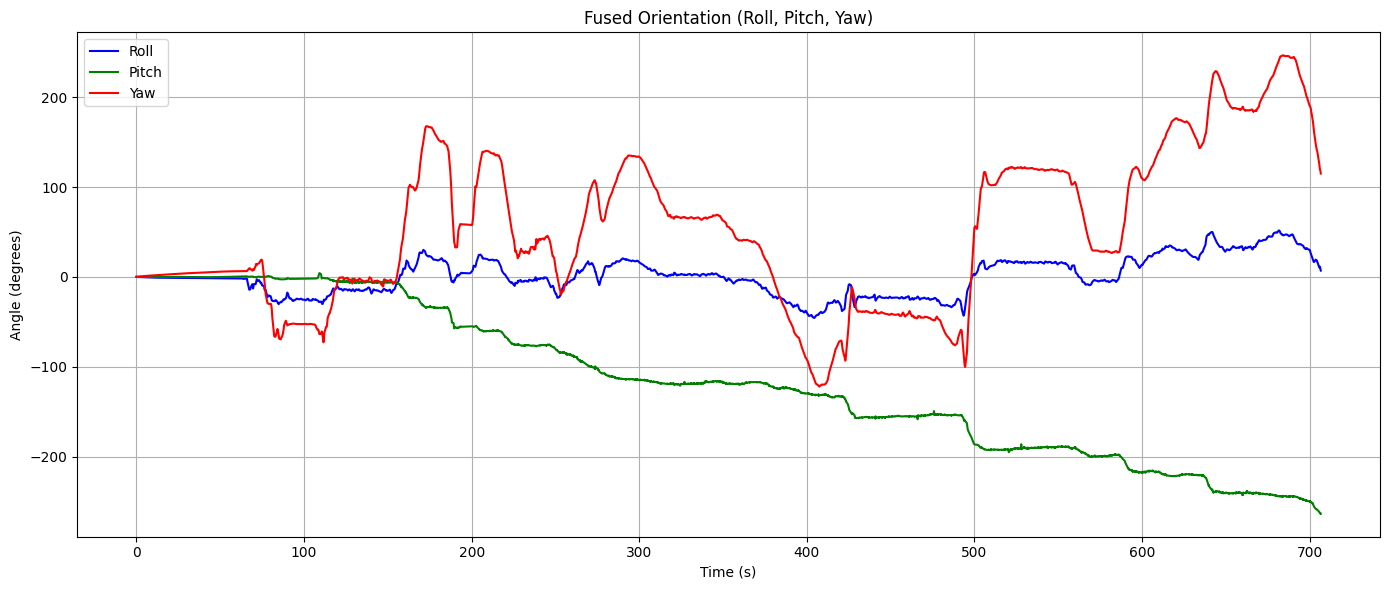

Video 2: ----------------------------------------------------------------------------------------------------


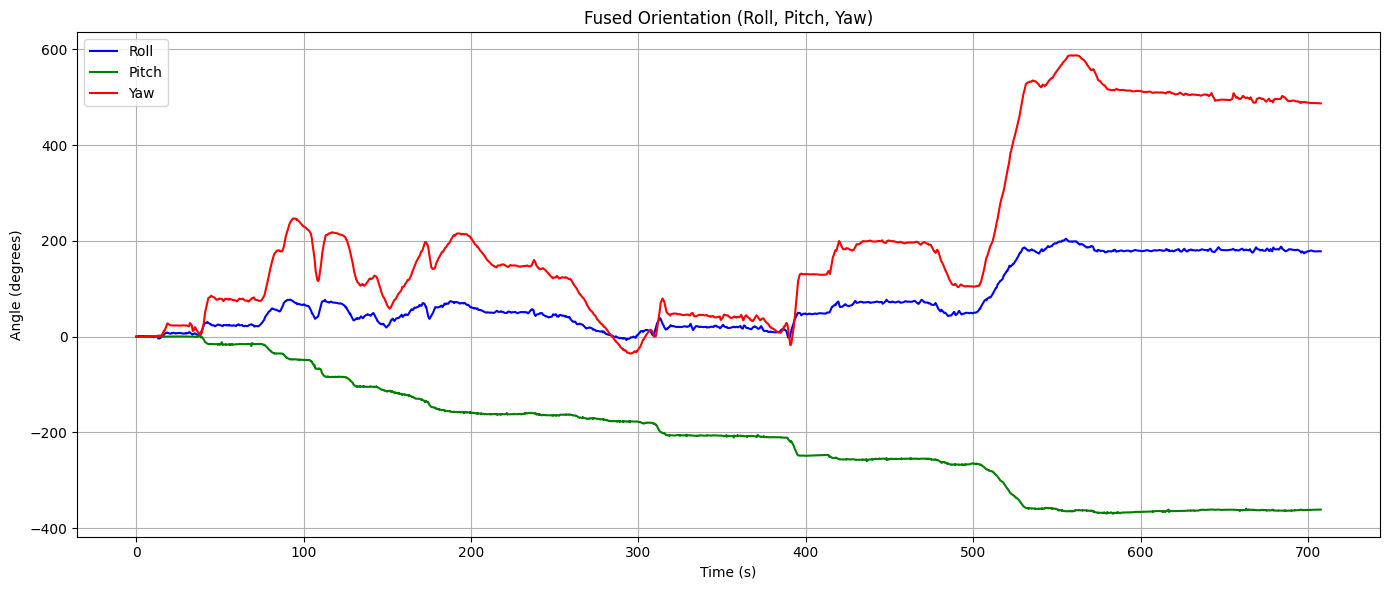

In [92]:
def plot_orientation(df, time_col="time_rel", title="Fused Orientation (Roll, Pitch, Yaw)"):
    """
    Plot roll, pitch, and yaw angles on the same graph over time.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns: time_col, 'roll', 'pitch', 'yaw' (angles in degrees).
    time_col : str
        Name of the time column in df.
    title : str
        Title for the plot.
    """
    plt.figure(figsize=(14, 6))

    plt.plot(df[time_col], df["roll"], label="Roll", color="blue")
    plt.plot(df[time_col], df["pitch"], label="Pitch", color="green")
    plt.plot(df[time_col], df["yaw"], label="Yaw", color="red")

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_orientation(complementary_filter_1)
print("Video 2:", "-" * 100)
plot_orientation(complementary_filter_2)

### Kalman Filter: sensor fusion
This provides the best results:
- Model sensor noise and bias
- Fuse ACCL (first step) + GYRO (second step) + MAGN (third step)
- Estimate full state with uncertainty

In [ ]:
def kalman_orientation_fusion_from_dfs(dfs, time_col="time_rel"):
    """
    Estimate roll, pitch, and yaw using a Kalman Filter from sensor data in a dict of DataFrames.

    Parameters
    ----------
    dfs : dict of pd.DataFrame
        Dictionary with keys like 'ACCL', 'GYRO', 'MAGN', each mapping to a DataFrame containing:
        - 3 axis data: e.g., 'ACCL_0', 'ACCL_1', 'ACCL_2'
        - a common time column (default 'time_rel').

    time_col : str
        Name of the column with time in seconds.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns: time, roll, pitch, yaw (in degrees).
    """
    # Extract data and align on common time
    df_acc = dfs.get("ACCL")
    df_gyro = dfs.get("GYRO")
    df_magn = dfs.get("MAGN")

    if df_acc is None or df_gyro is None or df_magn is None:
        raise ValueError("Missing one of required keys: 'ACCL', 'GYRO', 'MAGN'.")

    # Merge by time (inner join)
    df = pd.merge_asof(df_acc.sort_values(time_col),
                       df_gyro.sort_values(time_col),
                       on=time_col, suffixes=('_accl', '_gyro'))
    df = pd.merge_asof(df.sort_values(time_col),
                       df_magn.sort_values(time_col),
                       on=time_col)

    # Prepare sensor values
    acc = df[["ACCL_0", "ACCL_1", "ACCL_2"]].values
    gyro = df[["GYRO_0", "GYRO_1", "GYRO_2"]].values
    magn = df[["MAGN_0", "MAGN_1", "MAGN_2"]].values
    time = df[time_col].values
    dt = np.diff(time, prepend=time[0])

    n = len(time)
    angles = np.zeros((n, 3))  # [roll, pitch, yaw] in radians

    # Initial state and covariance
    x = np.zeros(3)
    P = np.eye(3) * 0.1
    Q = np.eye(3) * 0.00001  # Process noise, lower means more trust in gyroscope
    R = np.eye(3) * 10       # Measurement noise

    for i in range(1, n):
        # Predict
        dx = gyro[i] * dt[i]
        x = x + dx
        P = P + Q

        # Roll and pitch from accelerometer
        acc_x, acc_y, acc_z = acc[i]
        roll_acc = np.arctan2(acc_y, acc_z)
        pitch_acc = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))

        # Yaw from magnetometer (not tilt compensated)
        magn_x, magn_y = magn[i, 0], magn[i, 1]
        yaw_magn = np.arctan2(magn_y, magn_x)

        z = np.array([roll_acc, pitch_acc, yaw_magn])

        # Kalman Gain
        S = P + R
        K = P @ np.linalg.inv(S)

        # Update
        y = z - x
        x = x + K @ y
        P = (np.eye(3) - K) @ P

        angles[i] = x

    # Convert to degrees
    angles_deg = np.degrees(angles)

    return pd.DataFrame({
        time_col: time,
        "roll_kalman": angles_deg[:, 0],
        "pitch_kalman": angles_deg[:, 1],
        "yaw_kalman": angles_deg[:, 2]
    })

kalman_orientation_fusion_from_dfs_1 = kalman_orientation_fusion_from_dfs(dfs_video_1)
kalman_orientation_fusion_from_dfs_2 = kalman_orientation_fusion_from_dfs(dfs_video_2)

Video 1: ----------------------------------------------------------------------------------------------------


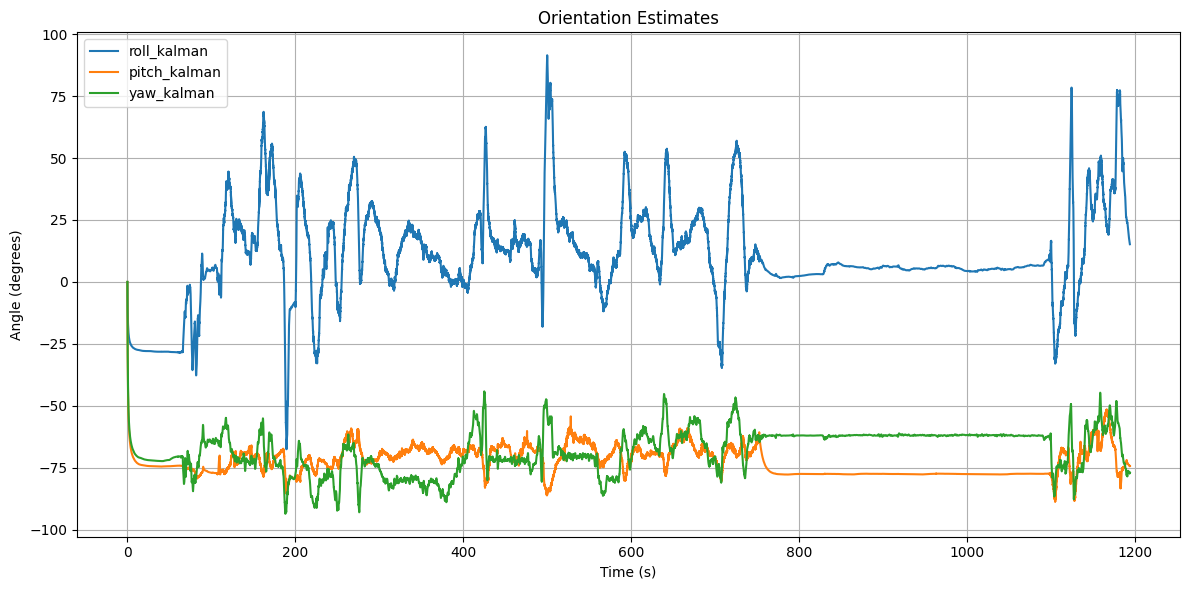

Video 2: ----------------------------------------------------------------------------------------------------


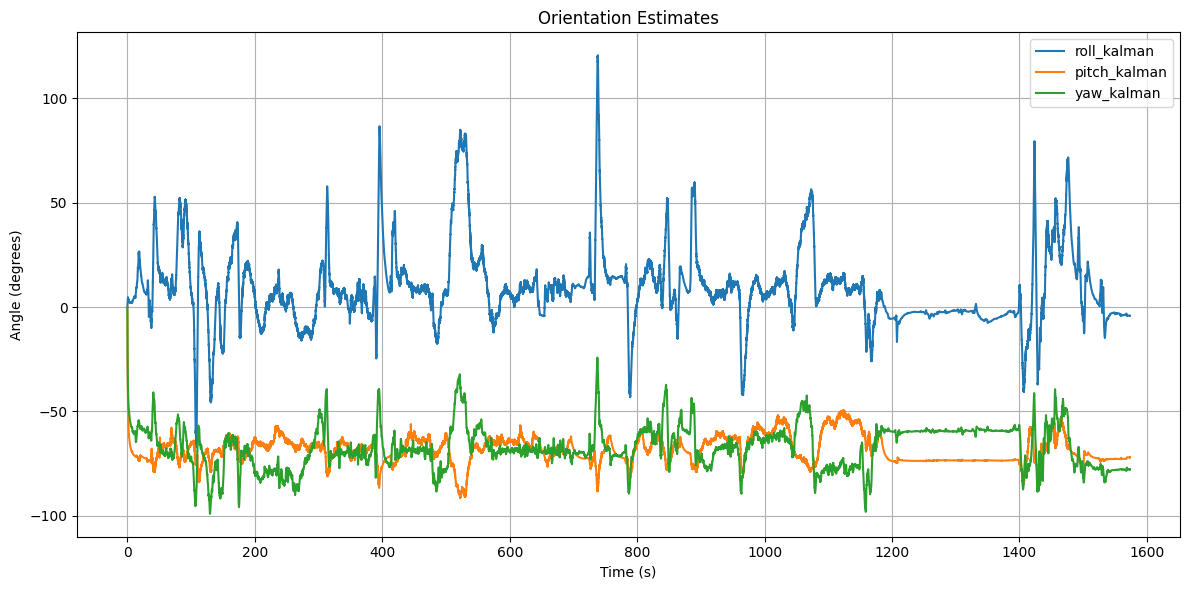

In [ ]:
def plot_orientation_estimates(df, time_col="time_rel", columns=None, title="Orientation Estimates"):
    """
    Plot roll, pitch, and yaw estimates over time.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing time and orientation estimates (in degrees).

    time_col : str
        Column name representing time.

    columns : list of str or None
        List of orientation columns to plot. Defaults to ['roll_kalman', 'pitch_kalman', 'yaw_kalman'].

    title : str
        Title of the plot.
    """
    if columns is None:
        # Default to Kalman output
        columns = ["roll_kalman", "pitch_kalman", "yaw_kalman"]

    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    plt.figure(figsize=(12, 6))
    for col in columns:
        plt.plot(df[time_col], df[col], label=col)

    plt.xlabel("Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("Video 1:", "-" * 100)
plot_orientation_estimates(kalman_orientation_fusion_from_dfs_1)
print("Video 2:", "-" * 100)
plot_orientation_estimates(kalman_orientation_fusion_from_dfs_2)

# Synchronisation des données et superposition sur vidéo